In [4]:
from asap.data.dataloader import DataSet
from asap.util import topics
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc

sample_in = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata_a_1_r_1.0_d_10000_s_2_sd_1'
sample_out = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/a_1_r_1.0_d_10000_s_2_sd_1/'

dl = DataSet(sample_in,sample_out,data_mode='sparse',data_ondisk=False)
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata_a_1_r_1.0_d_10000_s_2_sd_1
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/a_1_r_1.0_d_10000_s_2_sd_1/


In [5]:
dl.load_data()

In [6]:
dl.mtx.mean(0)

matrix([[  1.17272418,   0.        , 103.4022952 , ...,   0.        ,
           0.        ,   0.        ]])

<ipython-input-7-756ab8cbded8>:1: RuntimeWarning: divide by zero encountered in log
  m = np.log(dl.mtx).mean(0).T
<ipython-input-7-756ab8cbded8>:2: RuntimeWarning: divide by zero encountered in log
  v = np.log(dl.mtx).var(0).T
/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


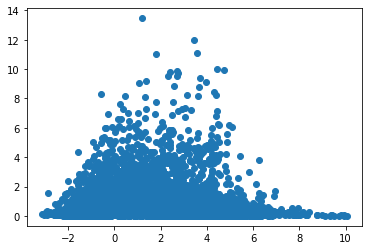

In [7]:
m = np.log(dl.mtx).mean(0).T
v = np.log(dl.mtx).var(0).T
# m
plt.plot(m,v,'o')

In [8]:
model = np.load(sample_out+'_dcnmf.npz')

In [ ]:
beta = model['beta']
theta = model['theta']
uu = beta.sum(0)
beta = beta/uu
prop = theta * uu
zz = prop.T.sum(0).reshape(theta.shape[0],1)
prop = prop/zz

df_beta = pd.DataFrame(beta.T)
df_beta.columns = dl.cols
df_theta = pd.DataFrame(prop)
df_theta.index = dl.rows
df_corr = pd.DataFrame(model['corr'])
df_corr.index = dl.rows

In [9]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = dl.cols
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.rows

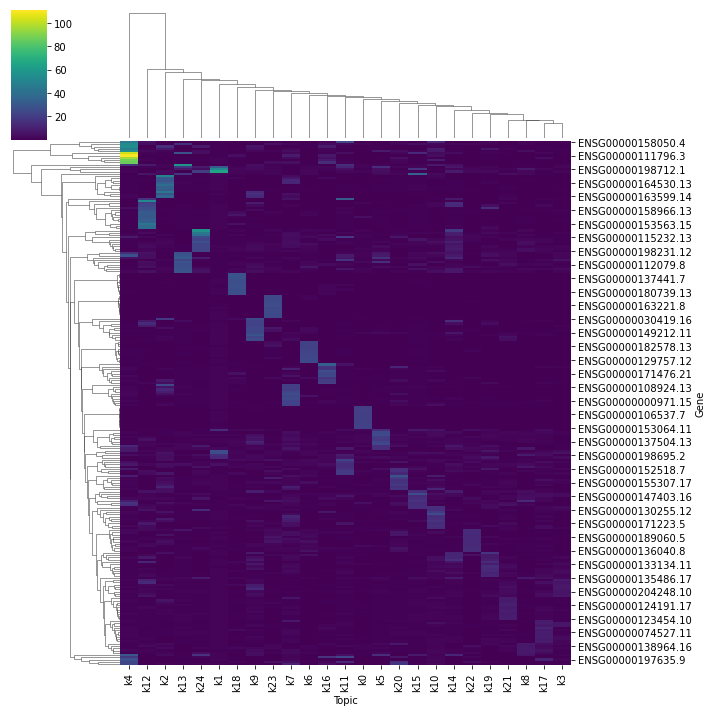

In [10]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [11]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=15, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_
df_umap['cell_type'] = [x.split('_')[1] for x in df_umap['cell']]

In [12]:
import umap

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.9,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,cell_type,umap1,umap2
0,0_NK_TPM,4,NK,-15.505228,-2.949042
1,1_NK_TPM,4,NK,-16.355953,-2.599379
2,0_THSTAR_TPM,10,THSTAR,-12.753983,-4.934906
3,1_THSTAR_TPM,10,THSTAR,-13.616180,-4.458983
4,0_TH1_TPM,12,TH1,-14.450736,-4.122063
5,1_TH1_TPM,3,TH1,-12.831697,-3.664015
6,0_B_CELL_NAIVE_TPM,5,B,-16.367697,-0.473315
7,1_B_CELL_NAIVE_TPM,5,B,-16.225859,-1.550696
8,0_TREG_MEM_TPM,6,TREG,-15.326846,-4.593595
9,1_TREG_MEM_TPM,6,TREG,-16.072105,-4.716284


Text(0, 0.5, 'UMAP2')

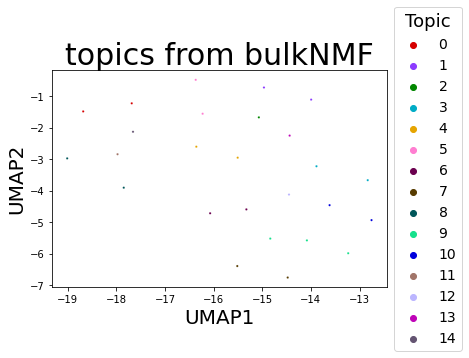

In [13]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

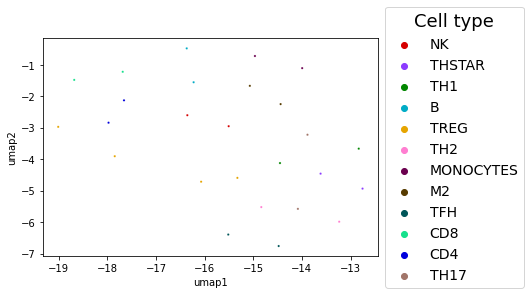

In [14]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='Cell type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
# p.set_xlabel("UMAP1",fontsize=20)
# p.set_ylabel("UMAP2",fontsize=20)

In [ ]:
df_scanpy = pd.read_csv(sample_out+'_scanpy.csv.gz')
df_umap = pd.merge(df_umap,df_scanpy,on='cell',how='left')
df_umap

In [ ]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cluster'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cluster',s=5,palette=cp,legend=True)
plt.legend(title='Cell type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
dl.load_data()
dl.mtx.shape

In [28]:

from anndata import AnnData
import scanpy as sc
import numpy as np

cols = pd.DataFrame(dl.cols).set_index(0)
rows = pd.DataFrame(dl.rows).set_index(0)
adata = AnnData(dl.mtx,rows,cols)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


adata.obs['pmf'] = df_umap['topic_bulk'].values.astype('str')
adata.obs

,pmf
0,
0_NK,5
1_NK,5
2_NK,5
3_NK,5
4_NK,5
...,...
395_TH17,7
396_TH17,7
397_TH17,7


In [29]:
sc.tl.rank_genes_groups(adata, 'pmf', method='wilcoxon')

... storing 'pmf' as categorical


In [ ]:
for group in groups:
    print(group,'--->', adata.uns['rank_genes_groups']['names'][group][0:8])

In [30]:
groups = adata.obs['pmf'].unique()
dfall = pd.DataFrame()
for group in groups:
    print(group)
    cols = list(adata.uns['rank_genes_groups']['names'][group])
    df = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][group]).T
    df.columns = cols
    df.index = ['k_'+group]
    dfall = pd.concat([dfall,df],axis=0,ignore_index=False)

5
12
1
9
7
3
0
8
13
4
6
2
11
10
14


In [ ]:
dfall

In [35]:
# bulk_data = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/resources/dice/mean_tpm_merged.csv.gz'
bulk_data = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/resources/dice/raw_merged.csv.gz'
df_dice = pd.read_csv(bulk_data)
df_dice = df_dice.rename(columns={'Unnamed: 0': 'gene'})
df_dice.columns = [x.replace('_TPM','')for x in df_dice.columns]

df_dice = df_dice.set_index('gene').T

In [36]:
df_dice = df_dice[dfall.columns]
df_dice

gene,ENSG00000134539.16,ENSG00000115523.16,ENSG00000100385.13,ENSG00000105374.9,ENSG00000180644.7,ENSG00000131018.22,ENSG00000100453.12,ENSG00000205336.11,ENSG00000150045.11,ENSG00000137441.7,...,ENSG00000023445.13,ENSG00000142676.12,ENSG00000152558.14,ENSG00000187109.13,ENSG00000174444.14,ENSG00000144802.11,ENSG00000026508.17,ENSG00000133112.16,ENSG00000156508.17,ENSG00000070756.15
NK,4.721437e+06,1.832108e+07,9.343059e+06,6.284419e+06,5.089733e+06,1.006319e+07,2.797076e+06,3.546897e+06,2.286945e+06,2.804341e+06,...,1.127452e+05,2.970151e+06,6.452191e+05,8.544437e+05,2.145089e+06,4.140831e+05,9.749717e+05,6.239784e+06,8.297256e+06,3.511732e+06
THSTAR,9.443486e+03,2.221554e+05,5.061923e+05,6.878615e+04,8.589169e+04,1.550494e+06,3.507553e+02,6.669014e+03,6.998990e+03,1.291722e+03,...,1.538901e+06,8.511458e+06,3.334202e+06,2.774496e+06,6.646284e+06,1.804423e+06,3.539507e+06,2.239645e+07,2.362167e+07,9.285091e+06
CD4_STIM,1.396151e+04,1.167305e+04,8.346811e+05,2.567132e+03,7.430251e+03,3.226373e+05,1.047263e+04,1.391747e+03,1.436550e+03,8.486762e+02,...,9.550440e+06,5.322603e+06,1.983519e+06,4.007289e+06,5.018757e+06,2.482191e+06,1.830012e+07,1.387419e+07,1.570767e+07,9.447988e+06
TH1,1.565306e+04,9.470356e+05,8.840197e+05,4.355270e+05,1.522495e+05,2.287731e+06,2.933344e+04,1.828526e+05,1.277286e+04,1.345956e+05,...,1.097916e+06,8.274577e+06,2.239103e+06,2.151847e+06,6.080138e+06,1.581051e+06,3.005779e+06,1.560477e+07,1.764265e+07,7.829720e+06
B_CELL_NAIVE,8.618682e+03,6.015224e+02,5.091454e+02,1.531895e+03,1.309496e+02,8.595145e+05,9.961601e+01,1.033820e+03,1.392031e+04,8.035462e+01,...,5.256471e+06,5.681439e+06,2.460727e+06,2.808132e+06,3.864752e+06,1.093334e+06,1.217911e+06,9.039224e+06,1.308669e+07,5.614174e+06
TREG_MEM,1.076850e+04,2.328136e+04,1.944796e+06,1.298725e+04,1.167221e+05,1.688065e+06,1.988867e+03,5.578303e+03,2.653808e+03,2.318229e+03,...,1.593936e+06,6.750097e+06,1.570419e+06,1.798658e+06,4.747249e+06,1.589736e+06,3.547991e+06,1.017506e+07,1.190438e+07,5.821054e+06
CD8_STIM,5.848227e+04,2.339641e+04,9.182562e+05,2.712801e+04,6.678889e+04,2.170522e+05,2.657814e+04,3.266762e+03,1.244420e+03,3.511014e+03,...,4.842754e+06,5.757090e+06,1.856522e+06,3.770543e+06,5.199831e+06,1.789113e+06,1.026332e+07,1.262257e+07,1.512302e+07,7.936020e+06
TH2,7.717325e+03,1.193647e+04,3.798027e+05,7.256646e+03,2.091872e+04,1.529898e+06,1.485467e+02,2.376112e+03,3.977257e+03,5.678289e+02,...,1.768538e+06,8.558904e+06,2.755377e+06,2.668915e+06,6.769511e+06,1.875518e+06,3.613714e+06,1.814523e+07,2.034557e+07,8.118316e+06
TREG_NAIVE,1.402260e+04,1.678527e+04,8.974841e+05,1.178468e+04,4.723598e+04,1.487799e+06,2.035540e+03,5.474707e+03,6.393778e+03,3.166901e+03,...,3.117913e+06,8.685040e+06,3.745079e+06,2.997911e+06,6.995247e+06,2.429487e+06,3.061239e+06,1.479704e+07,1.830000e+07,8.615111e+06
MONOCYTES,5.319199e+03,1.304883e+04,2.561774e+03,1.521791e+04,1.393406e+03,2.611572e+05,8.823723e+02,2.107219e+03,4.688885e+03,8.118746e+02,...,1.086317e+05,3.703608e+06,1.166622e+06,1.195806e+06,2.724380e+06,2.586169e+06,3.974795e+06,9.851361e+06,9.537894e+06,6.755774e+06


In [37]:
# sel_top_genes = list(np.unique(topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)['Gene'].values))
corr=[]
for i in dfall.index:
    cr = []
    for j in df_dice.index:
        cr.append(np.corrcoef(dfall.loc[i,:],df_dice.loc[j,:])[0,1])
    corr.append(cr)

df_corr = pd.DataFrame(corr)
df_corr.index = dfall.index
df_corr.columns = df_dice.index


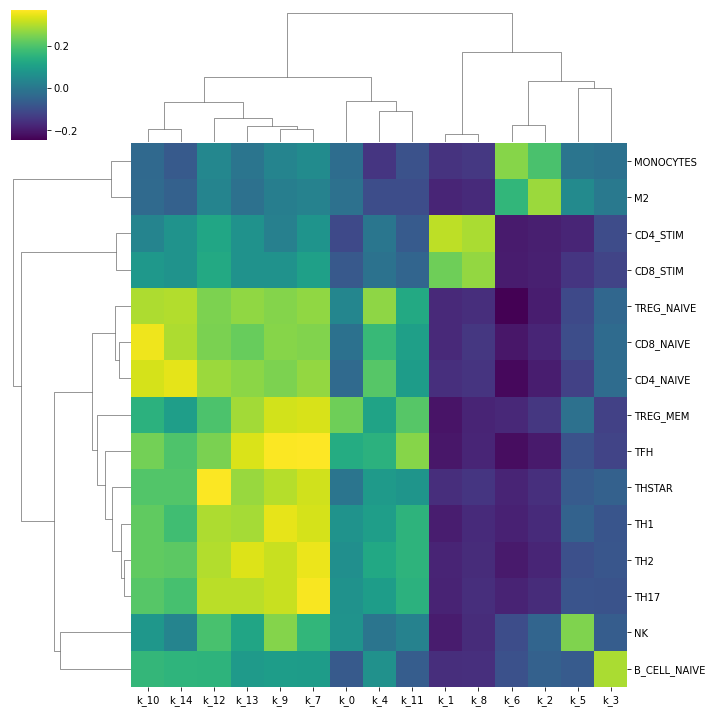

In [38]:
sns.clustermap(df_corr.T,cmap='viridis')


In [ ]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match

In [ ]:
sns.heatmap(df_match,cmap='viridis')

In [27]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.9336888399764588